# DEMO: Image Recommendation for Wikipedia Articles
## Article-level split, 38 epoch, precision = [8.4, 20.1, 29.6, 33.0, 132.3]

In [1]:
import os
import keras
from basic.common import readPkl
from w2vv_pred import W2VV_MS_pred, pred_mutual_error_ms
from util.text import encode_text
from util.text2vec import get_text_encoder
from util.util import readImgSents 
from simpleknn.bigfile import BigFile
from util.losser import get_losser
from util.evaluation import i2t

Using TensorFlow backend.


In [2]:
use_flickr = False

model_name = "flickr30k_trained_model" if use_flickr else "38_epoch_article_level"
# model_name = "flickr30k_trained_model" if use_flickr else "1000chars_description_trained_model"
trainCollection = "flickr30kenctrain" if use_flickr else 'data_w2vvtrain'
testCollection='data_w2vvtest'

In [3]:
model_path = os.path.join(os.environ['HOME'],'trained_w2vv_model/' + model_name)
abs_model_path = os.path.join(model_path, 'model.json')
weight_path = os.path.join(model_path, 'best_model.h5')
predictor = W2VV_MS_pred(abs_model_path, weight_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
08/01/2020 19:58:06 INFO [w2vv_pred.pyc.W2VV_MS_pred] loaded a trained Word2VisualVec model successfully


In [4]:
! sh ./do_gene_vocab.sh data_w2vvtrain 5

Using TensorFlow backend.
processing data_w2vvtrain ...
/home/oleh/VisualSearch/data_w2vvtrain/TextData/vocabulary/bow/word_vocab_5.txt exists. skip
Using TensorFlow backend.
processing data_w2vvtrain ...
/home/oleh/VisualSearch/data_w2vvtrain/TextData/vocabulary/bow_filterstop/word_vocab_5.txt exists. skip


In [5]:
# setup multi-scale sentence vectorization
opt = readPkl(os.path.join(model_path, 'option.pkl'))
# opt.n_caption = 2

rootpath=os.path.join(os.environ['HOME'],'VisualSearch')
rnn_style, bow_style, w2v_style = opt.text_style.strip().split('@')
text_data_path = os.path.join(rootpath, trainCollection, "TextData", "vocabulary", "bow", opt.rnn_vocab)
bow_data_path = os.path.join(rootpath, trainCollection, "TextData", "vocabulary", bow_style, opt.bow_vocab)
w2v_data_path = os.path.join(rootpath, "word2vec", opt.corpus,  opt.word2vec)

text2vec = get_text_encoder(rnn_style)(text_data_path)
bow2vec = get_text_encoder(bow_style)(bow_data_path)
w2v2vec = get_text_encoder(w2v_style)(w2v_data_path)

# similarity function
losser = get_losser(opt.simi_fun)()

08/01/2020 19:58:08 INFO [util/text2vec.pyc.Index2Vec] initializing ...
08/01/2020 19:58:08 INFO [util/text2vec.pyc.BoW2VecFilterStop] initializing ...
08/01/2020 19:58:08 INFO [util/text2vec.pyc.BoW2VecFilterStop] 47024 words
08/01/2020 19:58:08 INFO [util/text2vec.pyc.AveWord2VecFilterStop] initializing ...
[BigFile] 1743364x500 instances loaded from /home/oleh/VisualSearch/word2vec/flickr/vec500flickr30m


## Read Data

In [6]:
import numpy as np
import string
import json
import shutil

import os
from os import listdir, mkdir
from os.path import isfile, isdir, join, exists, abspath
from keras.preprocessing import image
from IPython.display import display, Image
import regex as re

In [7]:
def _remove_punctuation(text):
    return re.sub(ur"\p{P}+", "", text)

def _getJSON(path):
    with open(path) as json_file:
        return json.loads(json.load(json_file))

def _getTextFeatures(text_path):
    data = _getJSON(text_path)
    text = _remove_punctuation(data['text'].replace("\n", " "))
    text = text[:1000].rsplit(' ', 1)[0]
    # onyshchak: only checking first 1000 characters, will need to extract summary propely
    data["text"] = text
    return data

def _getImagesMeta(path):
    return _getJSON(path)['img_meta']

def _getValidImagePaths(article_path):
    img_path = join(article_path, 'img/')
    return [join(img_path, f) for f in listdir(img_path) if isfile(join(img_path, f)) and f[-4:].lower() == ".jpg"]

def _dump(path, data):
    with open(path, 'w', encoding='utf8') as outfile:
        json.dump(data, outfile, indent=2, ensure_ascii=False)

def GetArticleData(article_path):
    article_data = _getTextFeatures(join(article_path, 'text.json'))
    article_data["img"] = _getImagesMeta(join(article_path, 'img/', 'meta.json'))
    
    return article_data

def ReadArticles(data_path, pred=None, offset=0, limit=None):
    print("Reading in progress...")
    article_paths = [join(data_path, f) for f in listdir(data_path) if isdir(join(data_path, f))]
    limit = limit if limit else len(article_paths) - offset
    
    articles = []
    for i in range(offset, len(article_paths)):
        path = article_paths[i]
        if (i - offset + 1) % 251 == 0: print(i - offset, "articles have been read")
        article_data = GetArticleData(path)
        
        if pred and not pred(i, article_data): continue
        articles.append(article_data)
        if len(articles) >= limit: break  # useless?
        
    print(limit, "articles have been read")
    return articles

In [8]:
import random
import hashlib
from urllib import quote

random.seed(1234)

def get_matched_article_id(img_features, articles):
    for tries in range(50):
        i = int(random.random() * len(articles))
        page = articles[i]
        text = page["text"]
        print(i, page['title'])
        
        rnn_vec, bow_w2v_vec = encode_text(opt, text2vec, bow2vec, w2v2vec, text)
        predicted_features = predictor.predict_one(rnn_vec, bow_w2v_vec).reshape(1, -1)

        similarity = np.array(losser.calculate(predicted_features, img_features)[0])
        true_img = [x["filename"] for x in page["img"]]
        for x in images[similarity.argsort()[:10]]:
            if x["filename"] in true_img:
                print("FOUND", x["filename"])
                print(x["url"])
                return i
    return -1

def get_url(img_title, size=600):
    img_name = img_title.replace("\"", "")
    for forbidden in ':*?/\\ ':
        img_name = img_name.replace(forbidden, '_')
        
    img_name = img_name.encode('utf-8')
    url_prefix = "https://upload.wikimedia.org/wikipedia/commons/thumb/"
    md5 = hashlib.md5(img_name).hexdigest()
    sep = "/"
    
    img_name = quote(img_name)
    url = url_prefix + sep.join((md5[0], md5[:2], img_name)) + sep + str(size) + "px-" + img_name
    if url[-4:] != ".jpg" and url[-4:] != "jpeg":
        url += ".jpg"
        
    return url

In [9]:
%%time
articles = ReadArticles('../data/', offset=0, limit=None)

Reading in progress...
(250, 'articles have been read')
(501, 'articles have been read')
(752, 'articles have been read')
(1003, 'articles have been read')
(1254, 'articles have been read')
(1505, 'articles have been read')
(1756, 'articles have been read')
(2007, 'articles have been read')
(2258, 'articles have been read')
(2509, 'articles have been read')
(2760, 'articles have been read')
(3011, 'articles have been read')
(3262, 'articles have been read')
(3513, 'articles have been read')
(3764, 'articles have been read')
(4015, 'articles have been read')
(4266, 'articles have been read')
(4517, 'articles have been read')
(4768, 'articles have been read')
(5019, 'articles have been read')
(5270, 'articles have been read')
(5521, 'articles have been read')
(5638, 'articles have been read')
CPU times: user 50.2 s, sys: 6.16 s, total: 56.4 s
Wall time: 1min 1s


In [10]:
images = {i["filename"]: i for a in articles for i in a['img'] if "features" in i}
images = np.array([x for x in images.values()])

In [11]:
img_features = np.array([x["features"] for x in images], dtype=np.float32)

In [12]:
def wiki_predict(page, topK=10):
    text = page["text"]
    rnn_vec, bow_w2v_vec = encode_text(opt, text2vec, bow2vec, w2v2vec, text)
    predicted_features = predictor.predict_one(rnn_vec, bow_w2v_vec).reshape(1, -1)

    similarity = np.array(losser.calculate(predicted_features, img_features)[0])
    true_img_url = [get_url(x["title"]) for x in page["img"]]
    pred_img = images[similarity.argsort()[:topK]]
    pred_img_url = [get_url(x["title"]) for x in pred_img]
    
    print("Top-K Similiarity Score",similarity[similarity.argsort()[:topK]])
    
    return true_img_url, pred_img_url

def wiki_precision(page):
    text = page["text"]
    rnn_vec, bow_w2v_vec = encode_text(opt, text2vec, bow2vec, w2v2vec, text)
    predicted_features = predictor.predict_one(rnn_vec, bow_w2v_vec).reshape(1, -1)

    N = len(page["img"])
    similarity = np.array(losser.calculate(predicted_features, img_features)[0])
    pred_img = [x['filename'] for x in images[similarity.argsort()[:N]]]
    
    match = 0
    for i in page["img"]:
        if i['filename'] in pred_img:
            match += 1
    
    return float(match) / N

def calculate_ranked_loss(pred, label):
    def is_match(pred, label):
        return len([i for i in pred if i in label]) > 0
    
    K1 = is_match(pred[:1], label)
    K3 = is_match(pred[:3], label)
    K10 = is_match(pred, label)
    
    return (K1, K3, K10)

def wiki_precision_ranked(page):
    text = page["text"]
    rnn_vec, bow_w2v_vec = encode_text(opt, text2vec, bow2vec, w2v2vec, text)
    predicted_features = predictor.predict_one(rnn_vec, bow_w2v_vec).reshape(1, -1)

    N = len(page["img"])
    similarity = np.array(losser.calculate(predicted_features, img_features)[0])
    pred_img = [x['filename'] for x in images[similarity.argsort()[:N]]]
    img = [i['filename'] for i in page["img"]]
    
    return calculate_ranked_loss(pred_img, img)

def get_page_by_title(title, articles):
    return [a for a in articles if a['title'] == title][0]

In [13]:
import pandas as pd

df = pd.read_csv('test_articles_ids.txt', header=None)
ids = set(df[0])

In [14]:
test_articles = [a for a in articles if a['id'] in ids]
len(test_articles)

217

Got below articles from 217 test articles manually

In [15]:
# def calculate_loss_raw(A, B):
#     res = []
#     for a in A:
#         cur_res = []
#         for b in B:
#             b_split = b.split()
#             sim = -sum([y.lower() == x.lower() for x in a.split() for y in b_split])
#             cur_res.append(sim)
#         res.append(cur_res)
#     return np.array(res)

# def get_text_similarity(articles, images):
#     processed_titles = _getJSON("parsed_titles.json")
    
#     get_id = lambda x: os.path.splitext(x['filename'])[0]    
#     get_description = lambda x: x["description"] if x["description"] else processed_titles[get_id(x)]

#     X = np.array([x['title'] for x in articles])
#     y = np.array([get_description(x) for x in images])
    
#     s = calculate_loss_raw(X, y)
#     print(s.shape)
#     return s

# def get_image_similiarities(articles, images, predictor):
#     predicted_features = np.zeros(2048)
#     for a in articles:
#         text = a["text"]
#         rnn_vec, bow_w2v_vec = encode_text(opt, text2vec, bow2vec, w2v2vec, text)
#         features = predictor.predict_one(rnn_vec, bow_w2v_vec)
#         predicted_features = np.vstack((predicted_features, features))

#     img_features = np.array([x["features"] for x in images], dtype=np.float32)
#     s = np.array(losser.calculate(predicted_features[1:], img_features))
#     print(s.shape)
#     return s

# def wiki_text_predict(page, topK=10):
#     text = page["text"]
#     rnn_vec, bow_w2v_vec = encode_text(opt, text2vec, bow2vec, w2v2vec, text)
#     predicted_features = predictor.predict_one(rnn_vec, bow_w2v_vec).reshape(1, -1)

#     similarity = np.array(losser.calculate(predicted_features, img_features)[0])
#     true_img_url = [get_url(x["title"]) for x in page["img"]]
#     pred_img = images[similarity.argsort()[:topK]]
#     pred_img_url = [get_url(x["title"]) for x in pred_img]
    
#     print("Top-K Similiarity Score",similarity[similarity.argsort()[:topK]])
    
#     return true_img_url, pred_img_url

# def calculate_precision(article, images, similarity):
#     predictions = []
#     for s in similarity:
#         top_indeces = s.argsort()[:10]
#         predictions.append([x["filename"] for x in images[top_indeces]])
        
#     K1, K3, K10 = 0,0,0
#     for j, a in enumerate(test_articles):
#         label = [i['filename'] for i in a["img"]]
#         k1, k3, k10 = calculate_ranked_loss(predictions[j], label)
#         K1 += k1
#         K3 += k3
#         K10 += k10
    
#     return np.array([K1, K3, K10], dtype=np.float32) / len(test_articles) * 100

In [16]:
# random_page = get_page_by_title("Kennedy half dollar", articles)

In [17]:
# si = get_image_similiarities([random_page], images, predictor)[0]

In [18]:
# st = get_text_similarity([random_page], images)

In [19]:
# si = get_image_similiarities(test_articles, images, predictor)

In [20]:
# calculate_precision(test_articles, images, si)

In [21]:
# st = get_text_similarity(test_articles, images)

In [22]:
# calculate_precision(test_articles, images, st)

In [23]:
# calculate_precision(test_articles, images, (st / float(abs(np.min(st)))) + si)

In [24]:
# calculate_precision(test_articles, images, (st / 400) + si)

In [25]:
# get_id = lambda x: os.path.splitext(x['filename'])[0]
# processed_titles = _getJSON("parsed_titles.json")

In [26]:
# X = np.array([{
#     "features": x['title'],
#     "id": x['id'],
#     }
#     for x in test_articles
# ])


# get_description = lambda x: x["description"] if x["description"] else processed_titles[get_id(x)]
# y = np.array([{
#     "features": get_description(x),
#     "img_id": x['filename'],
#     }
#     for x in images
# ])

In [27]:
# y_features = np.array([x["features"] for x in y])
# X_features = np.array([x["features"] for x in X])

In [28]:
# similarity = calculate_loss_raw(X_features, y_features)
# similarity.shape

In [29]:
# predictions = []
# for s in similarity:
#     top_indeces = s.argsort()[:10]
#     predictions.append([x["img_id"] for x in y[top_indeces]])

In [30]:
# K1, K3, K10 = 0,0,0
# for j, a in enumerate(test_articles):
#     label = [i['filename'] for i in a["img"]]
#     k1, k3, k10 = calculate_ranked_loss(predictions[j], label)
#     K1 += k1
#     K3 += k3
#     K10 += k10
    
# np.array([K1, K3, K10], dtype=np.float32) / len(test_articles) * 100

## Prediction

In [31]:
# K = []
# for a in test_articles:
#     K.append(wiki_precision_ranked(a))
    
# K1, K3, K10 = 0,0,0
# for k1,k3,k10 in K:
#     K1 += k1
#     K3 += k3
#     K10 += k10
    
# np.array([K1, K3, K10], dtype=np.float32) / len(K)

In [32]:
# %%time
# pred = []
# for a in test_articles:
#     pred.append(wiki_precision(a))
    
# print(sum(pred) / len(pred))

In [33]:
import urllib2
import matplotlib.pyplot as plt
import PIL


def plot_matches(true_urls, pred_urls, title):
    fig,ax = plt.subplots(2,5, figsize=(20, 8))
    
    for i, img_url in enumerate(pred_urls):
        f = urllib2.urlopen(img_url)
        image = PIL.Image.open(f)
    
        k = i // 5
        m = i if i - 5 < 0 else i - 5
    
        color = "green" if img_url in true_urls else "red"
        ax[k][m].tick_params(axis='both', which='both', bottom='off',
                             top='off', labelbottom='off', right='off', left='off', labelleft='off')
        ax[k][m].set_xlabel(str(i + 1) + " ranked match")
        for d in ["left", "right", "bottom", "top"]:
            ax[k][m].spines[d].set_color(color)
            ax[k][m].spines[d].set_linewidth(4)
        ax[k][m].imshow(image, aspect='auto')
    

    plt.savefig(title + '.png')

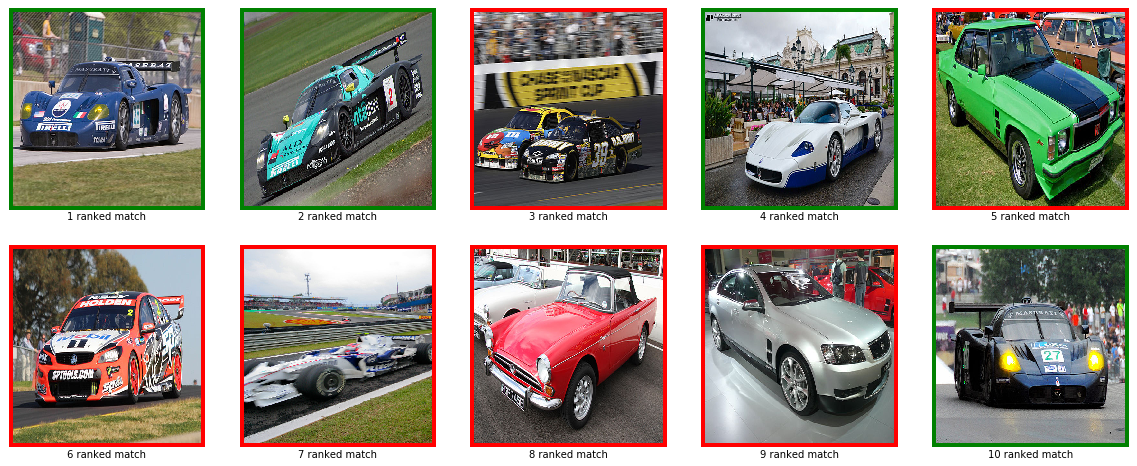

In [65]:
plot_matches(true_img_url, pred_img_url, random_page["title"])

In [35]:
def output_article_pred(title):
    random_page = get_page_by_title(title, articles)
    print("Input text", random_page["text"])
    
    true_img_url, pred_img_url = wiki_predict(random_page)
    plot_matches(true_img_url, pred_img_url, random_page["title"])

('Input text', u'Peking opera or Beijing opera  is the most dominant form of Chinese opera which combines music vocal performance mime dance and acrobatics It arose in Beijing in the midQing dynasty 16361912 and became fully developed and recognized by the mid19th century The form was extremely popular in the Qing court and has come to be regarded as one of the cultural treasures of China Major performance troupes are based in Beijing Tianjin and Shanghai The art form is also preserved in Taiwan where it is also known as   It has also spread to other regions such as the United States and Japan  Peking opera features four main role types sheng gentlemen dan women jing rough men and chou clowns Performing troupes often have several of each variety as well as numerous secondary and tertiary performers With their elaborate and colorful costumes performers are the only focal points on Peking operas characteristically sparse stage They use the skills of speech song dance and combat in moveme

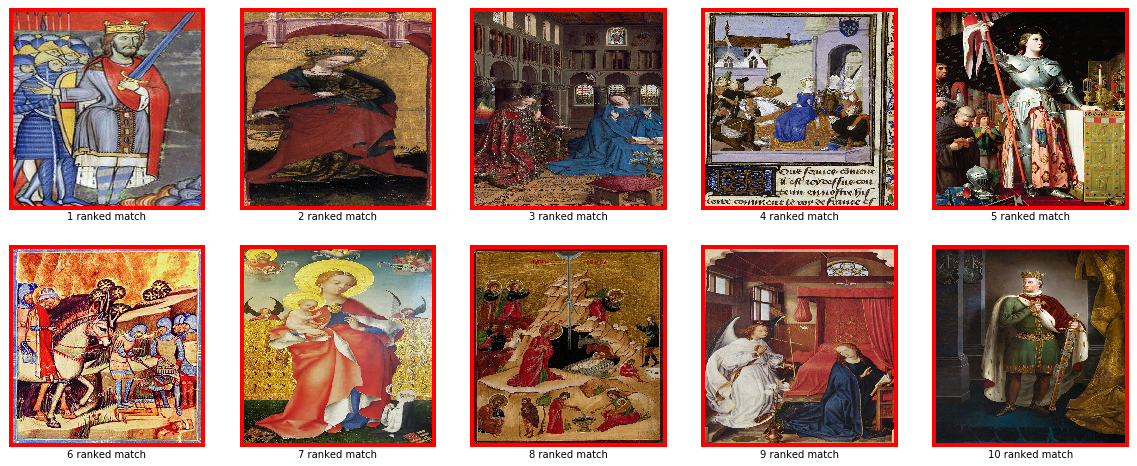

In [38]:
output_article_pred("Peking opera")

## Maserati MC12

In [18]:
random_page = get_page_by_title("Maserati MC12", articles)
print("Input text", random_page["text"])

('Input text', u'The Maserati MC12 Tipo M144S is a limited production twoseater sports car produced by Italian car maker Maserati to allow a racing variant to compete in the FIA GT Championship The car entered production in 2004 with 25 cars produced A further 25 were produced in 2005 making a total of 50 cars available for customers each of which was presold for \u20ac600000 US$670541 With the addition of 12 cars produced for racing only a total of 62 of these cars were ever produced  Maserati designed and built the car on the chassis of the Enzo Ferrari but the final car is much larger and has a lower drag coefficient The MC12 is longer wider and taller and has a sharper nose and smoother curves than the Enzo Ferrari which has faster acceleration better braking performance shorter braking distance and a higher top speed The top speed of the Maserati MC12 is 330 kilometres per hour 205\xa0mph whereas the top speed of the Enzo Ferrari is 350 kilometres per hour 2175\xa0mph  The MC12 wa

In [21]:
true_img_url, pred_img_url = wiki_predict(random_page)
# random_page["title"]

('Top-K Similiarity Score', array([-0.90462359, -0.89908424, -0.89662049, -0.89076115, -0.89044325,
       -0.88876566, -0.88868935, -0.88755314, -0.88269183, -0.88140706]))


OrderedDict([(u'left', <matplotlib.spines.Spine object at 0x7fb601f6ec10>), (u'right', <matplotlib.spines.Spine object at 0x7fb601f6ef10>), (u'bottom', <matplotlib.spines.Spine object at 0x7fb601fad510>), (u'top', <matplotlib.spines.Spine object at 0x7fb601fadb10>)])


ValueError: too many values to unpack

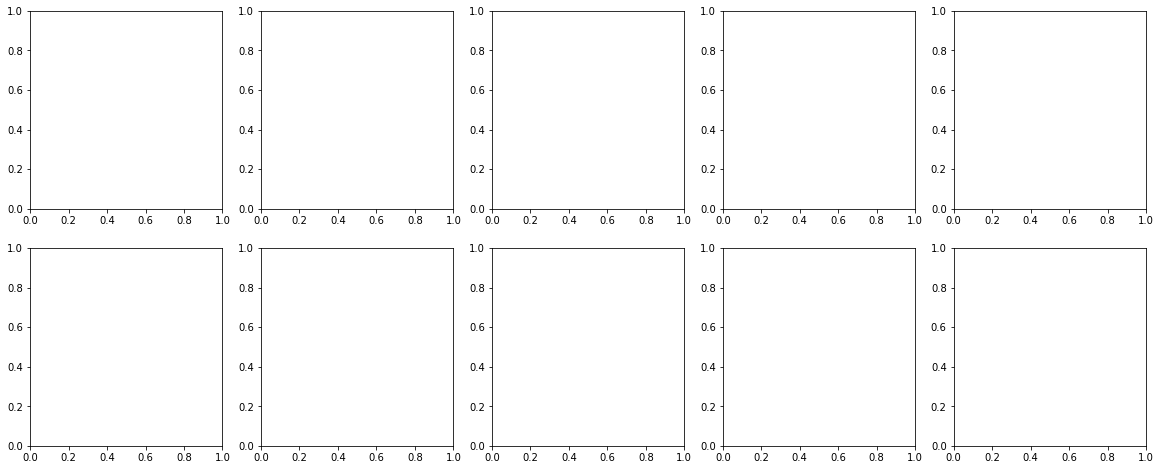

In [34]:
plot_matches(pred_img_url, random_page["title"])

#### Note

UPD: the only possible train article found so far is "2015 Formula One World Championship"

Very strange. Model which was never trained on Maserati images still guessed it pretty good. We either should have another Formula 1 bullet in the train dataset, or something here is really strange

## Jupiter

In [71]:
random_page = get_page_by_title("Jupiter", articles)
print("Input text", random_page["text"])

('Input text', u'Jupiter is the fifth planet from the Sun and the largest in the Solar System It is a gas giant with a mass onethousandth that of the Sun but twoandahalf times that of all the other planets in the Solar System combined Jupiter has been known to astronomers since antiquity It is named after the Roman god Jupiter When viewed from Earth Jupiter can be bright enough for its reflected light to cast shadows and is on average the thirdbrightest natural object in the night sky after the Moon and Venus  Jupiter is primarily composed of hydrogen with a quarter of its mass being helium though helium comprises only about a tenth of the number of molecules It may also have a rocky core of heavier elements but like the other giant planets Jupiter lacks a welldefined solid surface Because of its rapid rotation the planets shape is that of an oblate spheroid it has a slight but noticeable bulge around the equator The outer atmosphere is visibly segregated into several bands at differen

('Top-K Similiarity Score', array([-0.8847311 , -0.88138996, -0.88087438, -0.88060988, -0.88027845,
       -0.87979211, -0.87976401, -0.87962344, -0.87901226, -0.87599187]))


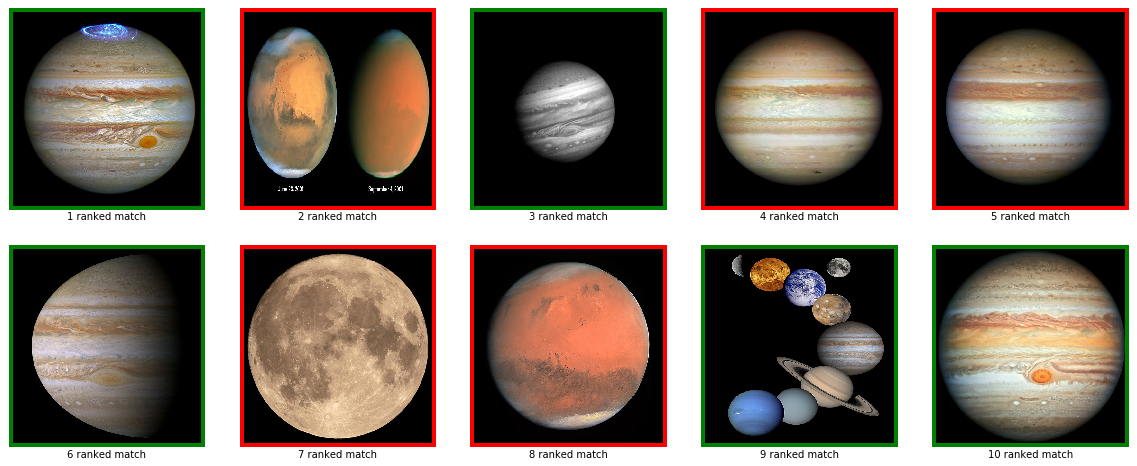

In [72]:
true_img_url, pred_img_url = wiki_predict(random_page)
plot_matches(true_img_url, pred_img_url, random_page["title"])

## Saturn

('Input text', u'Saturn is the sixth planet from the Sun and the secondlargest in the Solar System after Jupiter It is a gas giant with an average radius about nine times that of Earth It has only oneeighth the average density of Earth however with its larger volume Saturn is over 95 times more massive Saturn is named after the Roman god of wealth and agriculture its astronomical symbol \u2644 represents the gods sickle  Saturns interior is most likely composed of a core of ironnickel and rock silicon and oxygen compounds This core is surrounded by a deep layer of metallic hydrogen an intermediate layer of liquid hydrogen and liquid helium and finally a gaseous outer layer Saturn has a pale yellow hue due to ammonia crystals in its upper atmosphere An electrical current within the metallic hydrogen layer is thought to give rise to Saturns planetary magnetic field which is weaker than Earths but has a magnetic moment 580 times that of Earth due to Saturns larger size Saturns magnetic fi

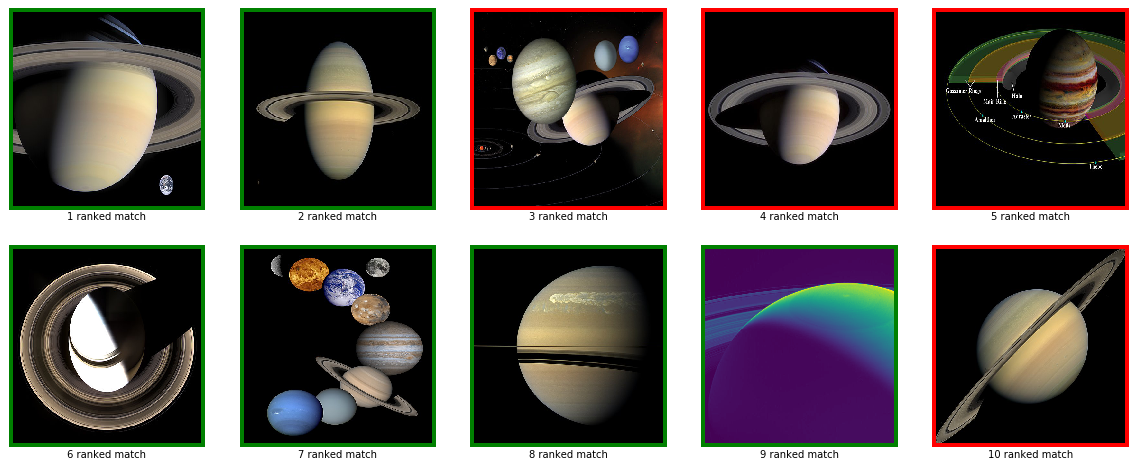

In [75]:
output_article_pred("Saturn")

## Emma Stone

('Input text', u'Emily Jean Emma Stone born November 6 1988 is an American actress The recipient of numerous accolades including an Academy Award and a Golden Globe Award she was the highestpaid actress in the world in 2017 Stone has appeared in Forbes Celebrity 100 in 2013 and in 2017 she was featured by Time as one of the 100 most influential people in the world  Born and raised in Scottsdale Arizona Stone began acting as a child in a theater production of The Wind in the Willows in 2000 As a teenager she relocated to Los Angeles with her mother and made her television debut in In Search of the New Partridge Family 2004 a reality show that produced only an unsold pilot After small television roles she made her film debut in Superbad 2007 and received positive media attention for her role in Zombieland 2009 The 2010 teen comedy Easy A was Stones first starring role earning her nominations for the BAFTA Rising Star Award and the Golden Globe Award for Best Actress This breakthrough was

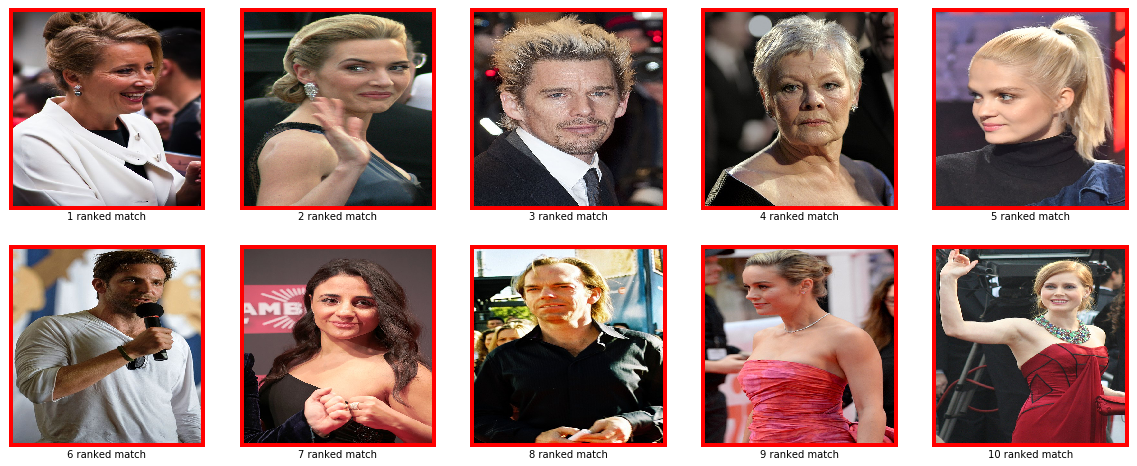

In [76]:
output_article_pred("Emma Stone")

('Input text', u'Rochester Castle stands on the east bank of the River Medway in Rochester Kent South East England The 12thcentury keep or stone tower which is the castles most prominent feature is one of the best preserved in England or France  Situated on the River Medway and Watling Street Rochester served as a strategically important royal castle During the late medieval period it helped protect Englands southeast coast from invasion The first castle at Rochester was founded in the aftermath of the Norman Conquest It was given to Bishop Odo probably by his halfbrother William the Conqueror During the Rebellion of 1088 over the succession to the English throne Odo supported Robert Curthose the Conquerors eldest son against William Rufus It was during this conflict that the castle first saw military action the city and castle were besieged after Odo made Rochester a headquarters for the rebellion After the garrison capitulated this first castle was abandoned  Between 1087 and 1089 Ru

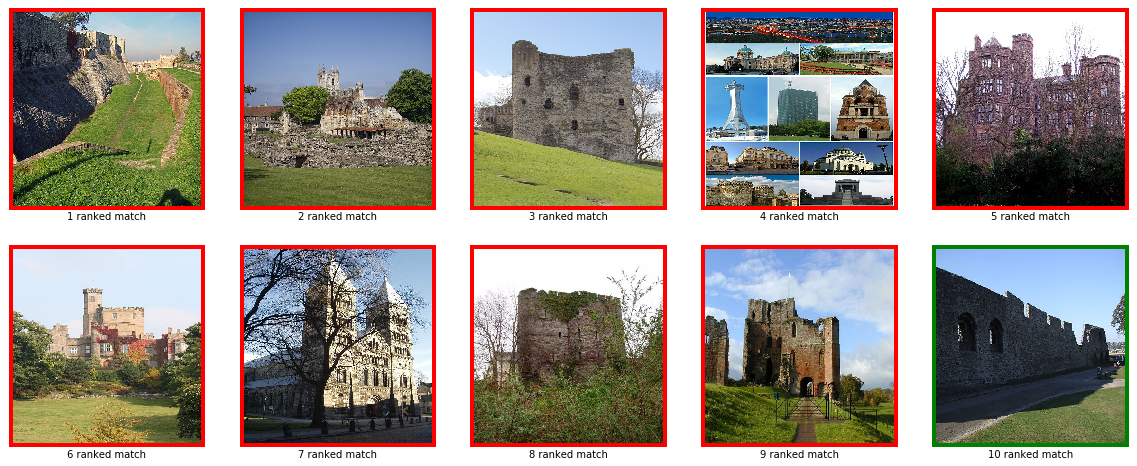

In [80]:
output_article_pred("Rochester Castle")

## Fauna of Puerto Rico

In [25]:
random_page = get_page_by_title("Fauna of Puerto Rico", articles)
print("Input text", random_page["text"])

('Input text', u'thumb|right|A common coqu\xed Eleutherodactylus coqui arguably the most recognizable species of Puerto Ricos fauna The fauna of Puerto Rico is similar to other island archipelago faunas with high endemism and low skewed taxonomic diversity Bats are the only extant native terrestrial mammals in Puerto Rico All other terrestrial mammals in the area were introduced by humans and include species such as cats goats sheep the small Asian mongoose and escaped monkeys Marine mammals include dolphins manatees and whales Of the 349 bird species about 120 breed in the archipelago and 475 are accidental or rare  The most recognizable and famous animal of Puerto Rico is probably the common coqu\xed a small endemic frog and one of the 86 species that constitute Puerto Ricos herpetofauna Some native freshwater fish inhabit Puerto Rico but some species introduced by humans have established populations in reservoirs and rivers The low richnesshigh diversity pattern is also apparent amo

In [26]:
true_img_url, pred_img_url = wiki_predict(random_page)
for x in pred_img_url:
    display(Image(url=x))

('Top-K Similiarity Score', array([-0.90020572, -0.89188923, -0.88724861, -0.88511734, -0.88205655,
       -0.87952055, -0.87901954, -0.87888725, -0.87830832, -0.87753646]))
